## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [265]:
#pip install yfinance

In [266]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from matplotlib import font_manager as fm
from matplotlib import rc

In [267]:
font_location = 'C:/Users/yeonn/AppData/Local/Microsoft/Windows/Fonts/D2Coding-Ver1.3.2-20180524-all.ttc' 
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [268]:
train = pd.read_csv('samsung.csv', encoding='cp949')

In [269]:
train

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
0,2024/10/04,60600,-700,-1.14,61000,61700,60500,24247578,1480865292580,361768822530000,5969782550
1,2024/10/02,61300,-200,-0.33,60500,61900,59900,28473536,1737678269615,365947670315000,5969782550
2,2024/09/30,61500,-2700,-4.21,64200,64300,61500,32694163,2043449921900,367141626825000,5969782550
3,2024/09/27,64200,-500,-0.77,64700,65400,64200,28433030,1842321896031,383260039710000,5969782550
4,2024/09/26,64700,2500,4.02,63900,64900,63700,37566015,2417513255958,386244930985000,5969782550
...,...,...,...,...,...,...,...,...,...,...,...
486,2022/10/12,55800,400,0.72,55700,57000,55200,18408910,1032656163200,333113866290000,5969782550
487,2022/10/11,55400,-800,-1.42,54400,55700,54000,21437877,1172168853325,330725953270000,5969782550
488,2022/10/07,56200,-100,-0.18,55900,56900,55200,16886813,949027146468,335501779310000,5969782550
489,2022/10/06,56300,300,0.54,56700,57300,56300,14944446,848081763100,336098757565000,5969782550


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [270]:
train.isnull().sum()

일자       0
종가       0
대비       0
등락률      0
시가       0
고가       0
저가       0
거래량      0
거래대금     0
시가총액     0
상장주식수    0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [271]:
train.set_index('일자', inplace=True)
train.sort_index(ascending=True, inplace=True)
# 2024년 7월 1일 이후의 데이터 삭제
train = train[train.index < '2024/07/01']

# 결과 출력
train

,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
일자,,,,,,,,,,
2022/10/05,56000,800,1.45,56900,57200,55400,22458970,1261934048318,334307822800000,5969782550
2022/10/06,56300,300,0.54,56700,57300,56300,14944446,848081763100,336098757565000,5969782550
2022/10/07,56200,-100,-0.18,55900,56900,55200,16886813,949027146468,335501779310000,5969782550
2022/10/11,55400,-800,-1.42,54400,55700,54000,21437877,1172168853325,330725953270000,5969782550
2022/10/12,55800,400,0.72,55700,57000,55200,18408910,1032656163200,333113866290000,5969782550
...,...,...,...,...,...,...,...,...,...,...
2024/06/24,80600,600,0.75,79700,80900,79500,15454227,1239803887850,481164473530000,5969782550
2024/06/25,80800,200,0.25,80600,81800,80100,19088458,1545796110887,482358430040000,5969782550
2024/06/26,81300,500,0.62,80100,81400,79900,17783242,1436019023400,485343321315000,5969782550


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

In [272]:
train.index = pd.to_datetime(train.index, format='%Y/%m/%d')

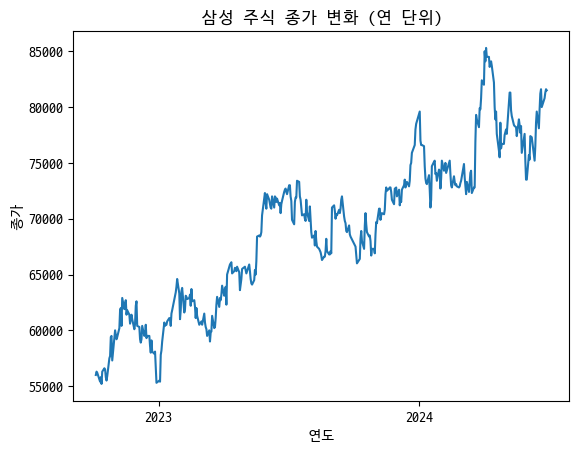

In [273]:
# lineplot 그리기
sns.lineplot(x=train.index, y=train['종가'])

# x축을 연 단위로 표시
ax = plt.gca()  # 현재의 Axes 객체 가져오기
ax.xaxis.set_major_locator(mdates.YearLocator())  # 주요 x축 레이블을 연 단위로 설정
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 연도 형식으로 설정

# 그래프 제목 및 라벨 설정
plt.title('삼성 주식 종가 변화 (연 단위)')
plt.xlabel('연도')
plt.ylabel('종가')

# 그래프 표시
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

사면안됌

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

1.평균과 분산이 일정하다\
2.시점에 의존하지 않고 시차에만 의존한다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [274]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# ADF Test 수행
adf_result = adfuller(train['종가'])

# 결과 출력 (ADF 통계량, p-value, 사용된 시차 수 등)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


ADF Statistic: -1.3390970249494973
p-value: 0.6111010799537093


2.3 ADF Test 결과를 해석하세요.

H0 : 시계열 데이터가 비정상성이다.\
H1 : 시계열 데이터가 정상성이다.

p-value <0.05 이므로 귀무가설을 기각할수 없음 -> 시계열이 정상성을 가지지못함

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF : MA 모형 검정\
PACF : AR 모형 검정

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

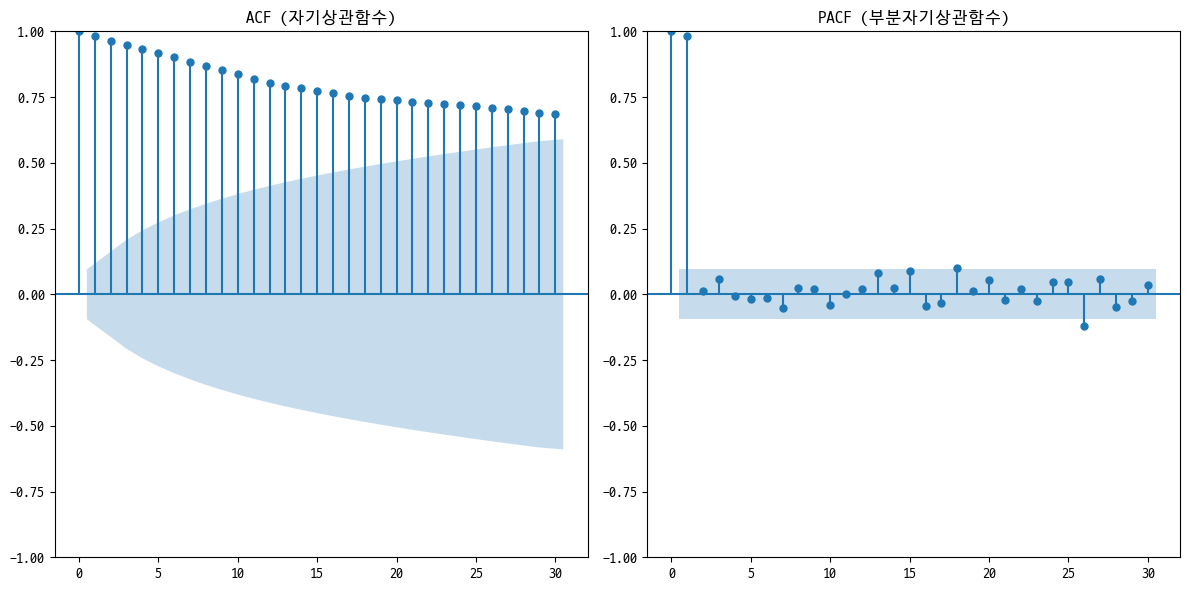

In [275]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF 그래프 출력
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  
plot_acf(train['종가'], lags=30, ax=plt.gca())
plt.title('ACF (자기상관함수)')

# PACF 그래프 출력
plt.subplot(1, 2, 2)  
plot_pacf(train['종가'], lags=30, ax=plt.gca())
plt.title('PACF (부분자기상관함수)')

# 그래프 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

ACF에서는 검정하지 못하고\
PACF에서 2번째 선이후부터 신뢰구간안에 들어가는 모형(급격히 감소한 모형)이기 때문에\
AR(2)모형이라고 볼수 있다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

<Figure size 1200x800 with 0 Axes>

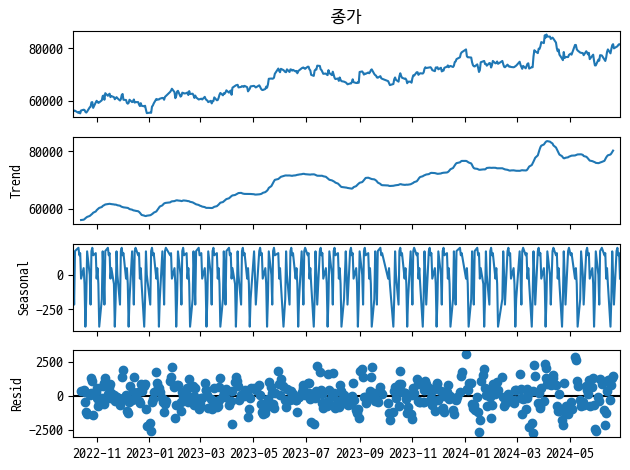

In [276]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 시계열 분해 (추세, 계절성, 잔차)
decomposition = seasonal_decompose(train['종가'], model='additive', period=12)  # 주기 설정

# 분해 결과 시각화
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

2.8 위 결과를 해석하세요.

최근까지 증가하는 Trend를 보여주다가 최근에는 감소함\
계절성이 있는걸 보여줌

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

평균일정하게 만들어주는거

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [279]:
from statsmodels.tsa.stattools import adfuller

# ADF 테스트 수행
adf_result = adfuller(train['Box-Cox 변환'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -9.104549276124501
p-value: 3.531411105641922e-15


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

C:\Users\yeonn\AppData\Local\Temp\ipykernel_14544\3523392066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['1차차분'] = train['종가'].diff()
C:\Users\yeonn\AppData\Local\Temp\ipykernel_14544\3523392066.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['계절차분'] = train['1차차분'].diff(12)
C:\Users\yeonn\AppData\Local\Temp\ipykernel_14544\3523392066.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

ADF Statistic: -9.104549276124501
p-value: 3.531411105641922e-15


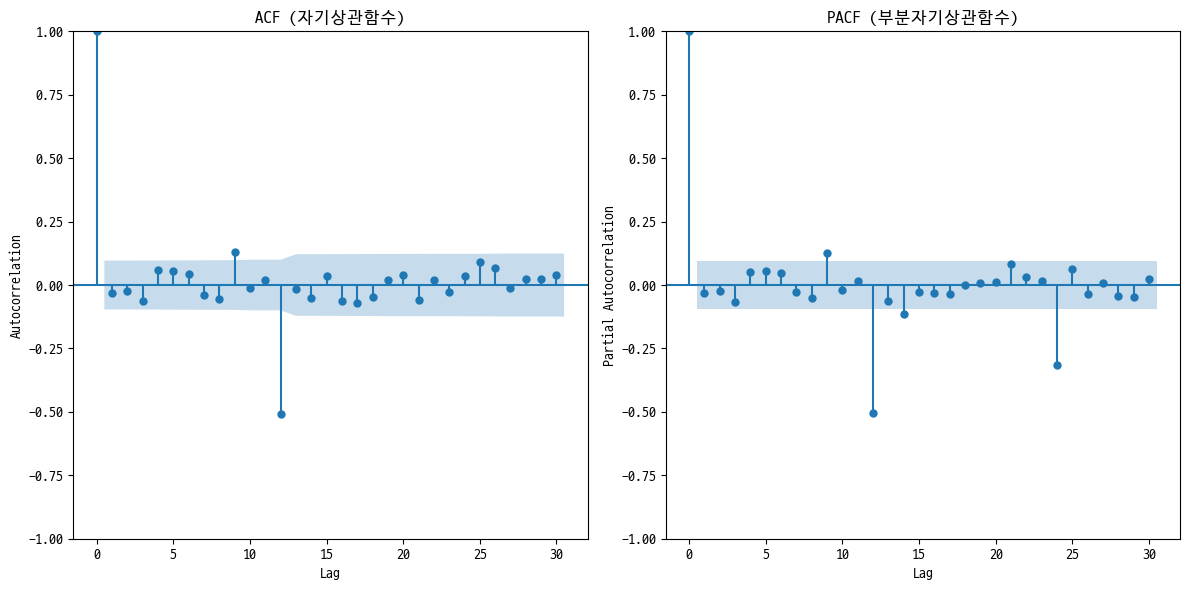

In [278]:
import pandas as pd
import numpy as np
from scipy import stats

# 1차 차분 수행
train['1차차분'] = train['종가'].diff()
train['계절차분'] = train['1차차분'].diff(12)


# Box-Cox 변환을 위한 NaN 제거
train = train.dropna()

# Box-Cox 변환을 위해 상수 추가 (최소값을 1 더함)
train['계절차분'] = train['계절차분'] + abs(train['계절차분'].min()) + 1

# Box-Cox 변환 수행
boxcox_transformed, lambda_opt = stats.boxcox(train['계절차분'])

# 변환된 값 추가
train['Box-Cox 변환'] = boxcox_transformed

# ADF 테스트 수행
adf_result = adfuller(train['Box-Cox 변환'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# ACF 및 PACF 그래프 출력
plt.figure(figsize=(12, 6))

# ACF 그래프
plt.subplot(1, 2, 1)  
plot_acf(train['Box-Cox 변환'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF (자기상관함수)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# PACF 그래프
plt.subplot(1, 2, 2)  
plot_pacf(train['Box-Cox 변환'].dropna(), lags=30, ax=plt.gca())
plt.title('PACF (부분자기상관함수)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

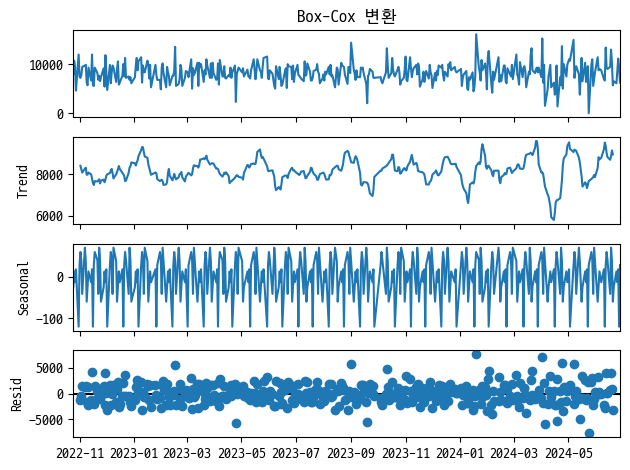

In [280]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 시계열 분해 (추세, 계절성, 잔차)
decomposition = seasonal_decompose(train['Box-Cox 변환'], model='additive', period=12)  # 주기 설정

# 분해 결과 시각화
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [281]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [282]:
train_diff

일자
2022-10-06     300.0
2022-10-07    -100.0
2022-10-11    -800.0
2022-10-12     400.0
2022-10-13    -600.0
               ...  
2024-09-26    2500.0
2024-09-27    -500.0
2024-09-30   -2700.0
2024-10-02    -200.0
2024-10-04    -700.0
Name: 종가, Length: 490, dtype: float64

In [283]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# 예를 들어 DataFrame df가 존재한다고 가정합니다.
# df = pd.DataFrame({'종가': [...]})

# SARIMA 모델 정의 (차수를 조정)
p = 3  # 비계절 AR 차수
d = 1  # 비계절 차분 차수
q = 3  # 비계절 MA 차수
P = 1  # 계절 AR 차수
D = 1  # 계절 차분 차수
Q = 1  # 계절 MA 차수
s = 12  # 계절 주기 (예: 월 단위 데이터에서 12)

# SARIMA 모델 피팅
model = SARIMAX(train['Box-Cox 변환'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# 모델 요약
print(results.summary())


C:\Users\yeonn\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\yeonn\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           Box-Cox 변환   No. Observations:                  414
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood               -3729.959
Date:                              Sun, 06 Oct 2024   AIC                           7477.917
Time:                                      22:00:28   BIC                           7513.863
Sample:                                           0   HQIC                          7492.151
                                              - 414                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7250      0.223     -7.721      0.000      -2.163      -1.287
ar.L2         -0.96

C:\Users\yeonn\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

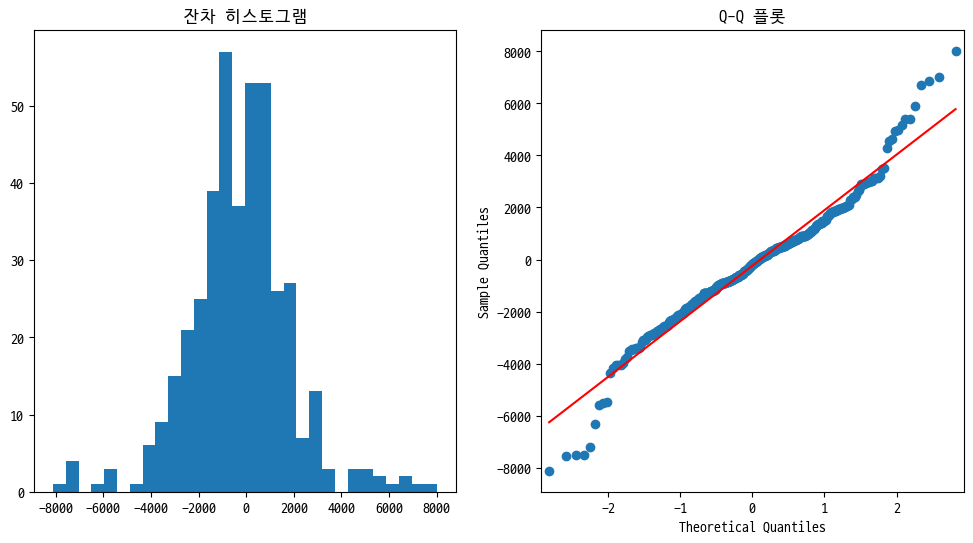

ADF Statistic: -5.346441378917414
p-value: 4.384515472898906e-06
Ljung-Box Statistic: 19.050179283073483
Ljung-Box p-value: 0.039629938864102064


In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# 잔차 계산
residuals = results.resid

# 1. 잔차의 시각화
plt.figure(figsize=(12, 8))

# 잔차의 히스토그램
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30)
plt.title('잔차 히스토그램')

# Q-Q 플롯
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q 플롯')
plt.show()

# ADF 테스트 및 Ljung-Box 테스트
from statsmodels.tsa.stattools import adfuller, acf, pacf

# ADF 테스트
adf_result = adfuller(residuals.dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Ljung-Box 테스트
lb_stat, lb_pvalue = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True).iloc[0]
print('Ljung-Box Statistic:', lb_stat)
print('Ljung-Box p-value:', lb_pvalue)

C:\Users\yeonn\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\yeonn\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


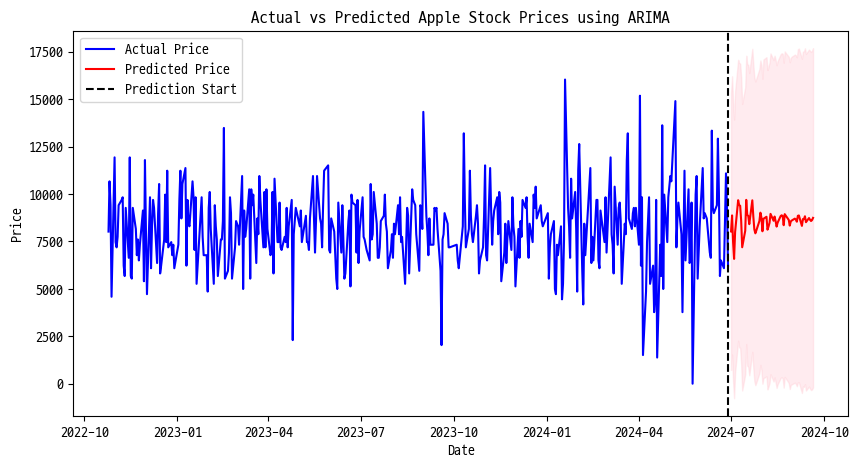

In [287]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = results.get_forecast(steps=60)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Box-Cox 변환'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=train.index[-1], periods=61, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=train.index[-1], periods=61, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=train.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [288]:
import yfinance as yf

#실제 데이터 가져오기
ticker = '005930.KS'  # 삼성전자 심볼
actual_data_last_50 = yf.download(ticker, start='2024-07-01', end='2024-10-01')
# 'Close' 열을 사용하여 실제 종가 데이터 가져오기
actual_last_50 = actual_data_last_50[['Close']]

[*********************100%***********************]  1 of 1 completed


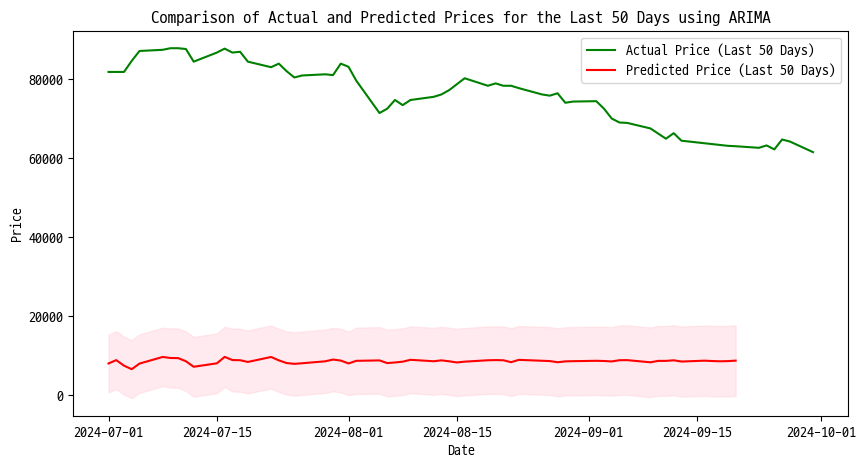

In [290]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=train['Box-Cox 변환'].index[-1], periods=61, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=train['종가'].index[-1], periods=61, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [293]:
pip install prophet


   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 991.0 kB/s eta 0:00:14
   ---------------------------------------- 0.2/13.3 MB 2.0 MB/s eta 0:00:07
    --------------------------------------- 0.2/13.3 MB 2.2 MB/s eta 0:00:07
    --------------------------------------- 0.3/13.3 MB 2.0 MB/s eta 0:00:07
    --------------------------------------- 0.3/13.3 MB 2.0 MB/s eta 0:00:07
   - -------------------------------------- 0.6/13.3 MB 2.3 MB/s eta 0:00:06
   - -------------------------------------- 0.6/13.3 MB 2.1 MB/s eta 0:00:07
   -- ------------------------------------- 0.9/13.3 MB 2.5 MB/s eta 0:00:05
   -- ------------------------------------- 0.9/13.3 MB 2.6 MB/s eta 0:00:05
   --- ------------------------------------ 1.2/13.3 MB 2.6 MB/s eta 0:00:05
   --- ------------------------------------ 1.2/13.3 MB 2.5 MB/s eta 0:00:05
   ---- ----------------------------------- 1.4/13.3 MB 2.5 MB/s eta 0:00:05
   


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [294]:
from prophet import Prophet

C:\Users\yeonn\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [295]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = '005930.KS'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%***********************]  1 of 1 completed


In [296]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

22:03:48 - cmdstanpy - INFO - Chain [1] start processing
22:03:49 - cmdstanpy - INFO - Chain [1] done processing


In [297]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

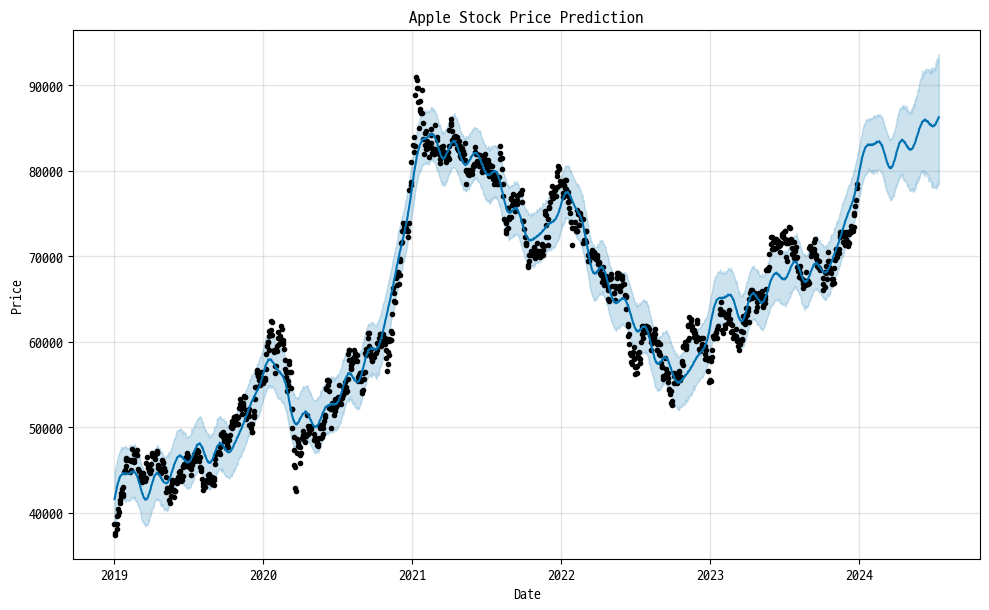

In [298]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

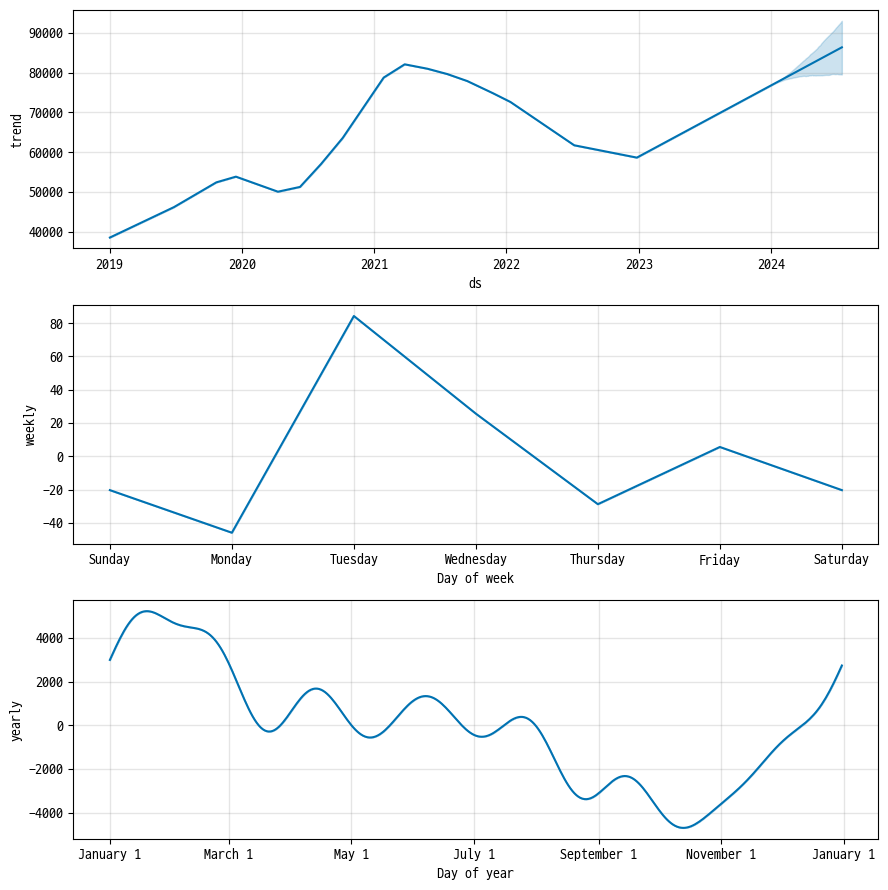

In [299]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [300]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%***********************]  1 of 1 completed


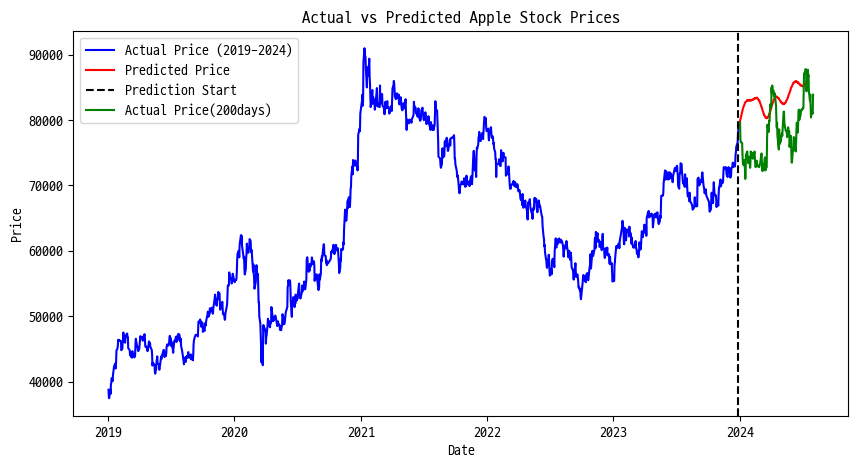

In [301]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다. 

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다. 

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.

#...